In [29]:
import torch
import torchvision
import pandas as pd
import os
from tqdm import tqdm
import pydicom
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from utils import normalize_dicom

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = torchvision.models.resnet18()
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = torch.nn.Linear(model.fc.in_features, 1)  
model = model.to(device)

model.load_state_dict(torch.load('frame_selection.pth'))

for param in model.parameters():
    param.requires_grad = False

In [191]:
df = pd.read_csv("data/v2/framerejectionfeedback.csv")
df = df.set_index("IMAGE_ID")

In [5]:
test_img_ids = pd.read_csv("testimgs.csv")
test_img_ids = set(test_img_ids.ID)

dcm_files = os.listdir("data/frame_selection/dicoms/")
dcm_files = [f for f in dcm_files if f.endswith(".dcm")]
dcm_files = [f for f in dcm_files if f.replace(".dcm", "") in test_img_ids]

parent = "data/frame_selection/dicoms/"
images = {}
for filename in tqdm(dcm_files):
    dcm = pydicom.dcmread(parent + filename)
    img = normalize_dicom(dcm)
    images[filename.replace(".dcm", "")] = img

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:25<00:00,  4.65it/s]


In [164]:
def plot_frame_selection(img_id):
    img = images[img_id] 

    img = torch.tensor(img).to(device).unsqueeze(1)
    probs = torch.sigmoid(model(img))
    probs = probs.squeeze(1).cpu().numpy()

    plt.figure(figsize=(12, 3)) 
    ax = sns.barplot(x=np.arange(len(probs)), y=probs, color="skyblue", width=0.8)
    ax.set_xticks(ax.get_xticks()[::2])

    max_prob_index = np.argmax(probs)
    ax.patches[max_prob_index].set_facecolor('blue')

    try:
        rejected = df.loc[img_id, "REJECTEDFRAME"]
        selected = df.loc[img_id, "SELECTEDFRAME"]
        for r in rejected.values if type(rejected)!=np.int64 else [rejected]:
            plt.axvline(x=r, color='red', linestyle='--', label='Rejected')
        for s in selected.values if type(selected)!=np.int64 else [selected]:
            plt.axvline(x=s, color='green', linestyle='--', label='Selected')
    except KeyError as e:
        print(f"{e} not found in framerejectionfeedback")

    plt.title('Model Output Probabilities')
    plt.show()

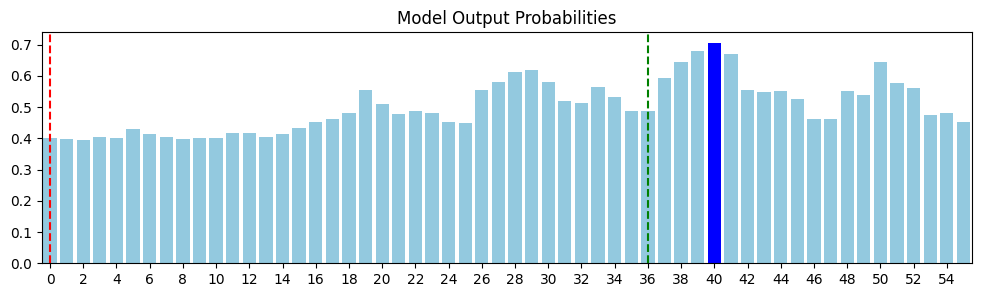

In [189]:
random_img_id = np.random.choice(list(images.keys()))
plot_frame_selection(random_img_id)

In [187]:
def imshow_frames(img_id, frames):
    img = images[img_id] 
    
    fig, axes = plt.subplots(1, len(frames), figsize=(3 * len(frames),  3))
    axes = axes.flatten()
    
    for ax, frame in zip(axes, frames):
        ax.imshow(img[frame])
        ax.axis('off')
        ax.text(0.1, 0.1, str(frame), fontsize=14, color='white', transform=ax.transAxes)

    plt.tight_layout()
    plt.show()

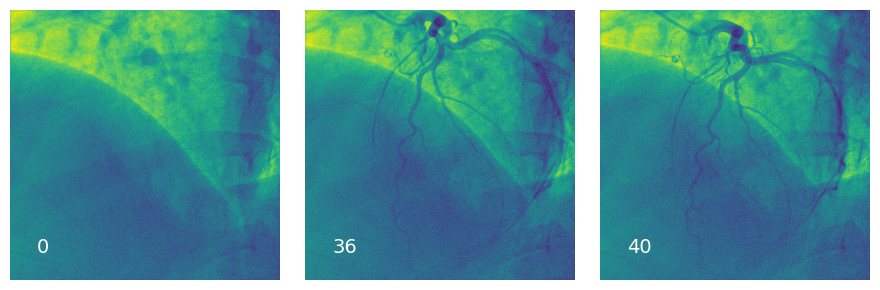

In [190]:
imshow_frames(random_img_id, [0, 36, 40])